<a href="https://colab.research.google.com/github/xRomory/CCADMACL_EXERCISES_COM231ML/blob/main/exercise_3b/devera_exercise3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 3B

In this exercise, you will explore how the DBSCAN clustering algorithm identifies dense groups and outliers in the Pokémon statistics dataset. You will analyze the dataset, scale features, determine DBSCAN parameters, run DBSCAN, and interpret the clustering results.

In [ ]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Download latest version
path = kagglehub.dataset_download("abcsds/pokemon")
print("Path to dataset files:", path)

Path to dataset files: /home/romory/.cache/kagglehub/datasets/abcsds/pokemon/versions/2


In [ ]:
if os.path.isdir(path):
  print(True)

contents = os.listdir(path)
contents

mydataset = path + "/" + contents[0]
mydataset


df = pd.read_csv(mydataset)

True


## 1. Load the Dataset (8 pts)

Load the Pokémon dataset into a pandas DataFrame.

Show the first five rows (3 pts)

In [ ]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False



How many Pokémon are in the dataset? (2 pts)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [ ]:
df.shape[0]

800

#### There are 800 Pokemons in the dataset


List all columns available (3 pts)

In [ ]:
df.columns

Index(['#', 'Name', 'Type 1', 'Type 2', 'Total', 'HP', 'Attack', 'Defense',
       'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'],
      dtype='object')

## 2: Select Features & Clean the Data (8 pts)

Select the numeric features needed for clustering (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed). (3 pts)

In [ ]:
features = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
data_features = df[features]
data_features.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,45,49,49,65,65,45
1,60,62,63,80,80,60
2,80,82,83,100,100,80
3,80,100,123,122,120,80
4,39,52,43,60,50,65


Are there any missing values? (2 pts)

In [ ]:
df.isna().sum()

#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

If missing values exist, describe how you handled them (3 pts)

In [ ]:
# In the Pokémon game, there are some Pokémons with 2 types, while some have only one.
# What we can do is fill those missing values with a "None" placeholder instead of dropping them
# This way we can keep keep all Pokémon, and we can indicate which Pokémon have only one type.
df["Type 2"] = df["Type 2"].fillna("None")
print(df["Type 2"].value_counts())
df.info()

Type 2
None        386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Ice          14
Rock         14
Water        14
Ghost        14
Fire         12
Electric      6
Normal        4
Bug           3
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      800 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64

# 3. Scale the Features (10 pts)

Apply StandardScaler to the selected features.

Show the transformed feature sample (e.g., first 5 rows) (10 pts)


In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_features)

# Convert back to DataFrame for easy viewing
scaled_df = pd.DataFrame(scaled_features, columns=data_features.columns)
scaled_df.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503
1,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015
2,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635
3,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635
4,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853


## 4. Determine a Suitable eps Value (10 pts)

Using k = 4:
Compute the distance to the 4th nearest neighbor for each Pokémon (6 pts)

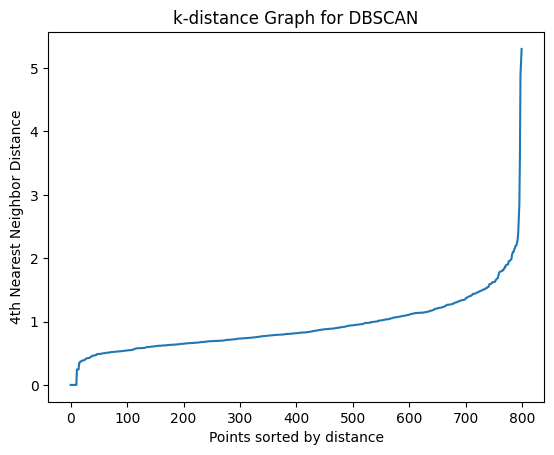

In [ ]:
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_df)
distances, _ = neighbors.kneighbors(scaled_df)

# Get the distance to the 4th nearest neighbor for each Pokémon
k_distances = np.sort(distances[:, 3])
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.title('k-distance Graph for DBSCAN')
plt.show()

In [ ]:
# Let's compute the elbow programatically

# k-distances already sorted
y = k_distances
x = np.arange(len(y))

# Line between first and last point
p1 = np.array([x[0], y[0]])
p2 = np.array([x[-1], y[-1]])

# Compute perpendicular distance from line
distances = np.abs(
    np.cross(p2 - p1, p1 - np.vstack((x, y)).T)
) / np.linalg.norm(p2 - p1)

elbow_index = np.argmax(distances)
optimal_eps = y[elbow_index]

print("Optimal eps:", optimal_eps)

if 1.4 <= optimal_eps <= 2.0:
    print("Accepted eps:", optimal_eps)
else:
    print("Fallback to visual range")

Optimal eps: 1.5248638064269173
Accepted eps: 1.5248638064269173


/tmp/ipykernel_43864/2388791849.py:13: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  np.cross(p2 - p1, p1 - np.vstack((x, y)).T)


What is your chosen eps based on the "elbow"? (2 pts)

**My chosen eps is: 1.5**

- The plot showed us that there's an elbow between ~1.4-2.0 before shooting upward past 2.0. Upon computing it programatically, it showed us that the elbow index value was around ***1.5248638064269173*** or simply ***1.5***

One-sentence explanation of your reasoning (2 pts)

- The eps value of 1.5 was selected as it corresponds to the elbow of the k-distance plot, representing the point of maximum curvature where distances begin to increase rapidly.

## 5. Run DBSCAN (10 points)

Run DBSCAN using your chosen eps and min_samples


How many clusters did DBSCAN find? (4 pts)

In [ ]:
min_samples = [4, 6, 8, 10, 12, 15]

for min_sample in min_samples:
    db = DBSCAN(eps=1.5, min_samples=min_sample, metric="euclidean")
    db.fit(scaled_df)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"min_samples={min_sample}: clusters={n_clusters}")

min_samples=4: clusters=1
min_samples=6: clusters=2
min_samples=8: clusters=1
min_samples=10: clusters=1
min_samples=12: clusters=1
min_samples=15: clusters=1


Upon experimenting with different min_samples, min_samples=6 gives us 2 clusters.

***With an eps of 1.5 and min_samples of 6, DBSCAN found 2 clusters***

How many Pokémon were labeled as noise? (4 pts)

In [ ]:
db = DBSCAN(eps=1.5, min_samples=6, metric="euclidean")
db.fit(scaled_df)
labels = db.labels_
n_noise = list(labels).count(-1)
print(f"noise points={n_noise}")


noise points=44


min_samples=6 gives us 44 noise points.

With an eps of 1.5 and min_samples of 6, ***DBSCAN found 44 noise points***

Show the unique labels output by DBSCAN (2 pts)

In [ ]:
print("Unique labels:", np.unique(labels))

Unique labels: [-1  0  1]


## 6. Attach Cluster Labels to the Original Dataset (7 points)

Add the cluster labels back to the original DataFrame (3 pts)

In [ ]:
# Add cluster labels to the DataFrame
df['cluster'] = db.labels_

Show the first 10 rows including the cluster label (4 pts)

In [ ]:
df.head(10)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,cluster
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,0
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,0
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,0
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False,0
4,4,Charmander,Fire,None,309,39,52,43,60,50,65,1,False,0
5,5,Charmeleon,Fire,None,405,58,64,58,80,65,80,1,False,0
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False,0
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False,0
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False,0
9,7,Squirtle,Water,None,314,44,48,65,50,64,43,1,False,0


## 7. Explore the Clusters (12 points)

For each cluster:


How many Pokémon does it contain? (4 pts)

In [ ]:
df["cluster"].value_counts()

cluster
 0    750
-1     44
 1      6
Name: count, dtype: int64

What are the average Attack, Defense, and Speed? (4 pts)


In [ ]:
df.groupby("cluster")[["Attack", "Defense", "Speed"]].mean()

,Attack,Defense,Speed
cluster,,,
-1,104.545455,88.909091,73.886364
0,77.665333,72.318667,68.068000
1,58.666667,153.833333,53.333333


Compare the clusters: What differences do you notice? (4 pts)

Based on the results on the average of the 3 stats "Attack", "Defense", and "Speed":
- The outlier Pokemons have a high Attack stat
- Cluster 1 have balanced across the 3 stats
- Cluster 2 have high Defense stat

## 8. Identify Outliers (10 points)

List all Pokémon labeled as noise (cluster = -1) (4 pts)

In [ ]:
df[df["cluster"] == -1]
df[df["cluster"] == -1]["Name"]

19       BeedrillMega Beedrill
44                  Jigglypuff
71       AlakazamMega Alakazam
87         SlowbroMega Slowbro
103                       Onix
121                    Chansey
155                    Snorlax
163        MewtwoMega Mewtwo X
164        MewtwoMega Mewtwo Y
196      AmpharosMega Ampharos
217                  Wobbuffet
224        SteelixMega Steelix
230                    Shuckle
232    HeracrossMega Heracross
261                    Blissey
269                      Lugia
313                    Slaking
316                   Shedinja
321                   Hariyama
333          AggronMega Aggron
350                    Wailmer
351                    Wailord
354      CameruptMega Camerupt
414                   Regirock
415                     Regice
422        KyogrePrimal Kyogre
424      GroudonPrimal Groudon
426      RayquazaMega Rayquaza
428         DeoxysNormal Forme
429         DeoxysAttack Forme
431          DeoxysSpeed Forme
454                  Rampardos
473     

Are many of them legendary? (3 pts)

In [ ]:
legendary_outliers = df[(df["cluster"] == -1) & (df["Legendary"] == True)]
print(legendary_outliers[['Name', 'Legendary', 'cluster']])
print(f"Number of legendary outliers: {legendary_outliers.shape[0]}")

                      Name  Legendary  cluster
163    MewtwoMega Mewtwo X       True       -1
164    MewtwoMega Mewtwo Y       True       -1
269                  Lugia       True       -1
414               Regirock       True       -1
415                 Regice       True       -1
422    KyogrePrimal Kyogre       True       -1
424  GroudonPrimal Groudon       True       -1
426  RayquazaMega Rayquaza       True       -1
428     DeoxysNormal Forme       True       -1
429     DeoxysAttack Forme       True       -1
431      DeoxysSpeed Forme       True       -1
544  GiratinaAltered Forme       True       -1
796    DiancieMega Diancie       True       -1
798     HoopaHoopa Unbound       True       -1
Number of legendary outliers: 14


- There are 14 Legendary Pokemons out of 44 outliers

Explain why DBSCAN might classify them as outliers (3 pts)

- DBSCAN classifies these Pokémon as outliers because their extreme or unbalanced stat distributions—such as very high Attack compared to typical Pokémon, which place them in low-density regions of the feature space, often amplified by legendary and Mega forms. Though there are some Pokemons that are not in their Mega Form or not a Legendary Pokemon but they have unusually high attack stats and therefore lack enough nearby neighbors within the chosen eps radius.

## 9. Interpret the Clustering Results (25 points)
Write a short interpretation (4–6 sentences).
Discuss:


What types of Pokémon grouped together (5 pts)

In [ ]:
# Combine Type 1 and Type 2
types_long = pd.concat([
    df[["cluster", "Type 1"]].rename(columns={"Type 1": "Type"}),
    df[["cluster", "Type 2"]].rename(columns={"Type 2": "Type"})
]).dropna()

types_no_none_values = types_long[types_long["Type"] != "None"]

types_no_none_values.groupby(["cluster", "Type"]).size().sort_values(ascending=False)

cluster  Type    
 0       Water       121
         Flying       98
         Normal       95
         Grass        94
         Psychic      77
         Bug          68
         Ground       63
         Fire         61
         Poison       61
         Dark         50
         Rock         50
         Fighting     49
         Electric     49
         Dragon       47
         Steel        42
         Ghost        41
         Fairy        37
         Ice          35
-1       Psychic      12
         Normal        7
         Rock          5
         Water         5
         Bug           4
         Fighting      4
         Ghost         4
         Ground        4
 1       Steel         4
         Rock          3
-1       Ice           3
         Fire          3
         Dragon        3
         Steel         3
         Flying        3
         Fairy         2
         Electric      1
         Dark          1
         Poison        1
         Grass         1
 1       Fairy         1
       

Cluster 0 contains the majority of Pokémon and shows a wide mix of common types such as Water, Flying, Normal, Grass, and Psychic, indicating a dense group of generally balanced and frequently occurring Pokémon.

Cluster 1 is small and dominated by Steel and Rock types, which aligns with its higher average Defense stat and suggests that DBSCAN grouped together more defensive, armor-like Pokémon.

The outlier cluster (-1) is enriched with Psychic, Dragon, and other rare or powerful types, many of which are legendary or Mega forms with extreme stat values.
This indicates that DBSCAN separated Pokémon with unusually high or specialized stats into the noise cluster due to their low local density.
Overall, the clustering reflects meaningful groupings based on both Pokémon types and underlying stat distributions rather than random assignment.

Whether the clusters make intuitive sense (10 pts)

The clusters produced by DBSCAN make intuitive sense when considering both Pokémon types and stat distributions.

Cluster 0 groups together common Pokémon types such as Water, Normal, and Grass, which typically have balanced Attack, Defense, and Speed values and form a dense region in the dataset.

Cluster 1 is dominated by Steel and Rock types, which intuitively aligns with their very high Defense stats and lower Speed, making them distinct from the main group.

The outlier cluster consists largely of legendary, Mega, and special-form Pokémon with extreme or highly specialized stats, such as Mewtwo and Rayquaza.
Because these Pokémon are rare and do not have enough nearby neighbors in the feature space, DBSCAN correctly classifies them as noise rather than forcing them into clusters.

What the noise points reveal about DBSCAN (5 pts)

The noise points highlight DBSCAN’s strength in identifying data points that do not belong to any dense region. Many of the noise Pokémon are legendary, Mega, or special-form Pokémon, which have extreme or highly specialized stat values. Because DBSCAN relies on local density, these Pokémon lack enough nearby neighbors within the chosen eps radius and are therefore labeled as noise. This shows that DBSCAN does not force every data point into a cluster, unlike centroid-based algorithms such as K-Means.

Overall, the noise points demonstrate DBSCAN’s ability to isolate rare and exceptional Pokémon rather than misclassifying them.

What stat patterns you discovered (5 pts)

The clustering revealed clear stat-based patterns among the Pokémon.
Cluster 0 consists of Pokémon with relatively balanced Attack, Defense, and Speed values, representing the typical stat distribution in the dataset.

Cluster 1 is characterized by very high Defense and lower Speed, which aligns with Steel- and Rock-type Pokémon.

The noise points tend to have extreme stat values, such as very high Attack or highly skewed stat distributions.

These patterns suggest that DBSCAN effectively grouped Pokémon based on similarities in their overall stat profiles.